# Reddit Comment Generator

We will first see if we can generate highly upvoted reddit comments using a language model. Next it would be cool to score a given reddit comment, predicting its upvotes just from the text.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os

import requests
import numpy as np
import pandas as pd
import dill as pickle

PATH='/root/data/reddit/'

### Fetch training data

First let's download all the reddit comments from 2005 - 2010.

The latest we can go is 11/2017.

In [2]:
os.makedirs(f'{PATH}/raw', exist_ok=True)
os.makedirs(f'{PATH}/models', exist_ok=True)

In [3]:
# Generate filenames for downloads
year, end_year = 2005, 2010
month, end_month = 12, 2

files = []
while year < end_year or (year == end_year and month <= end_month):
    files.append(f'RC_{year}-{month:02}')
    # Increment through dates
    month += 1
    if month % 13 == 0:
        month = 1
        year += 1

In [5]:
# Idempotently download files from pushshift.io
BASE_URL = 'http://files.pushshift.io/reddit/comments/'
for filename in files:
    target_file = f'{PATH}raw/{filename}.bz2'
    if os.path.exists(target_file):
        print(f'Found {target_file}', end=', ')
        continue
    
    alt_name = f'{PATH}raw/{filename}'
    if os.path.exists(alt_name):
        print(f'Found {filename}', end=', ')
        continue
        
    print(f'\nDownloading {filename}...', end=' ')
    response = requests.get(f'{BASE_URL}{filename}.bz2', stream=True)
    response.raise_for_status()

    with open(target_file, 'wb') as f:
        for block in response.iter_content(1024):
            f.write(block)
    
    print('done')

Found /root/data/reddit/raw/RC_2005-12.bz2, Found /root/data/reddit/raw/RC_2006-01.bz2, Found /root/data/reddit/raw/RC_2006-02.bz2, Found /root/data/reddit/raw/RC_2006-03.bz2, Found /root/data/reddit/raw/RC_2006-04.bz2, Found /root/data/reddit/raw/RC_2006-05.bz2, Found /root/data/reddit/raw/RC_2006-06.bz2, Found /root/data/reddit/raw/RC_2006-07.bz2, Found /root/data/reddit/raw/RC_2006-08.bz2, Found /root/data/reddit/raw/RC_2006-09.bz2, Found /root/data/reddit/raw/RC_2006-10.bz2, Found /root/data/reddit/raw/RC_2006-11.bz2, Found /root/data/reddit/raw/RC_2006-12.bz2, Found /root/data/reddit/raw/RC_2007-01.bz2, Found /root/data/reddit/raw/RC_2007-02.bz2, Found /root/data/reddit/raw/RC_2007-03.bz2, Found /root/data/reddit/raw/RC_2007-04.bz2, Found /root/data/reddit/raw/RC_2007-05.bz2, Found /root/data/reddit/raw/RC_2007-06.bz2, Found /root/data/reddit/raw/RC_2007-07.bz2, Found /root/data/reddit/raw/RC_2007-08.bz2, Found /root/data/reddit/raw/RC_2007-09.bz2, Found /root/data/reddit/raw/RC_2

In [6]:
# Extract bzip2 archives into plain text - this is ~34 million comments
!ls {PATH}raw/*.bz2 | xargs -I % sh -c "bzip2 -d %"

### Read training data into memory

We're going to read all our training data into a dataframe.


In [8]:
%%time
import json

ids = []
bodys = []
max_comments = 1e5

for file in files:
    with open(f'{PATH}raw/{file}') as f:
        print(f'reading {file}', end=', ')
        for line in f.readlines():
            line_json = json.loads(line)
            if len(line_json['body']) > 30:
                ids.append(line_json['id'])
                bodys.append(line_json['body'])
            
        if len(ids) > max_comments:
            break

columns = ['id', 'body']
df = pd.DataFrame(columns=columns).astype(str)
df['id'] = ids
df['body'] = bodys
df = df.set_index('id')                

reading RC_2005-12, reading RC_2006-01, reading RC_2006-02, reading RC_2006-03, reading RC_2006-04, reading RC_2006-05, reading RC_2006-06, reading RC_2006-07, CPU times: user 1.37 s, sys: 22 ms, total: 1.39 s
Wall time: 1.39 s


In [9]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 107171 entries, c13 to cbsvm
Data columns (total 1 columns):
body    107171 non-null object
dtypes: object(1)
memory usage: 1.6+ MB
None


,body
id,
c13,A look at Vietnam and Mexico exposes the myth ...
c14,"The site states ""What can I use it for? Meetin..."
c15,Jython related topics by Frank Wierzbicki
c17,Saft is by far the best extension you could ta...
c19,How to take panoramic shots simply


In [10]:
train_percent = 0.8
valid_idx = int(len(df) * 0.8)
train_df = df[:valid_idx]
valid_df = df[valid_idx:]

### TODO

- dump a pickle of the model for the vocab
- start training model
- test model
- try with more files
- once language generation works - try training an upvote predictor with a small number of comments

In [14]:
import spacy
from fastai.nlp import LanguageModelData
from torchtext import vocab, data
from torchtext.datasets import language_modeling

In [26]:
import torch
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

True
True


In [16]:
TEXT = data.Field(lower=True, tokenize="spacy")

In [17]:
%%time
BATCH_SIZE = 64
BACKPROP_THRU_TIME = 70
MIN_WORD_FREQ = 10

model_data = LanguageModelData.from_dataframes(
    path=PATH,
    field=TEXT,
    col='body',
    train_df=train_df,
    val_df=valid_df,
    bs=BATCH_SIZE,
    bptt=BACKPROP_THRU_TIME,
    min_freq=MIN_WORD_FREQ
)

CPU times: user 1min 56s, sys: 1.3 s, total: 1min 57s
Wall time: 1min 57s


In [18]:
pickle.dump(TEXT, open(f'{PATH}models/TEXT.pkl','wb'))

In [19]:
print('Num batches: ', len(model_data.trn_dl))
print('Num unique tokens in vocab: ', model_data.nt)
print('Num sentences in train: ', len(model_data.trn_ds[0].text))

Num batches:  1301
Num unique tokens in vocab:  16390
Num sentences in train:  5837403


In [20]:
EMBEDDING_SIZE = 200
NUM_LAYER_WEIGHTS = 500
NUM_LAYERS = 3

In [21]:
# Reduce gradient descent momentum parameter, because
# we were told to and who's going to throw away free advice?
from functools import partial
import torch.optim as optim
optimization_func = partial(optim.Adam, betas=(0.7, 0.99))

In [29]:
from fastai.lm_rnn import seq2seq_reg
# Dropout parameters may need turning
learner = model_data.get_model(
    optimization_func, 
    EMBEDDING_SIZE,
    NUM_LAYER_WEIGHTS,
    NUM_LAYERS,
    dropouti=0.05,
    dropout=0.05,
    wdrop=0.1,
    dropoute=0.02,
    dropouth=0.05
)
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip = 0.3

In [30]:
learner.lr_find()

  0%|          | 0/1301 [00:00<?, ?it/s]


RuntimeError: shape '[1000000, 1]' is invalid for input of size 2000

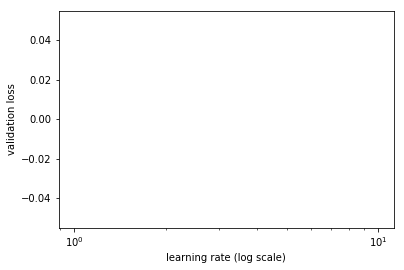

In [28]:
learner.sched.plot()